In [92]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
import gzip

In [93]:
def parseData(fname):
    for l in gzip.open(fname):
        yield eval(l)

data = list(parseData("australian_user_reviews.json.gz"))

dm = [[0,0],[0,0]]

users = set()
games = set()

nodate = 0

reviews = []

for user in data:
    if user["user_id"] in users:
        #print(f"ducplicate user skipped: {user['user_id']}")
        pass
    else:
        users.add(user["user_id"])
        for review in user["reviews"]:
            games.add(review["item_id"])
            funny = review["funny"]
            hasfunny = int(funny != "")
            if funny == "":
                review["funny"] = 0
            else:
                review["funny"] = int(re.findall("\d+", funny)[0])
                
            helpful = review["helpful"]
            hashelpful = int(helpful != "No ratings yet")
            if helpful == "No ratings yet":
                review["helpful_n"] = 0
                review["helpful_total"] = 0
                review["helpful"] = 0
            else:
                nums = re.findall("\d+", helpful.replace(",", ""))
                helpfulness = float(nums[0]) / float(nums[1])
                review["helpful"] = float(nums[0]) / float(nums[1])
                review["helpful_n"] = int(nums[0])
                review["helpful_total"] = int(nums[1])
            
            dm[hasfunny][hashelpful] += 1

            try:
                post_datetime = datetime.strptime(review["posted"],'Posted %B %d, %Y.')
                review["posted"] = post_datetime
            except:
                nodate += 1

            review["user_id"] = user["user_id"]
            review["user_url"] = user["user_url"]
            reviews.append(review)

In [94]:
print(f"\t\tno helpful\thas hepful\nno funny\t{dm[0][0]}\t\t{dm[0][1]}\nhas funny\t{dm[1][0]}\t\t{dm[1][1]}")
print(f"num unique users: {len(users)}")
print(f"num unique games: {len(games)}")
print(f"num reviews: {len(reviews)}")
print(f"num reviews with bad date format: {nodate}")

		no helpful	has hepful
no funny	28791		21629
has funny	940		7070
num unique users: 25485
num unique games: 3682
num reviews: 58430
num reviews with bad date format: 9932


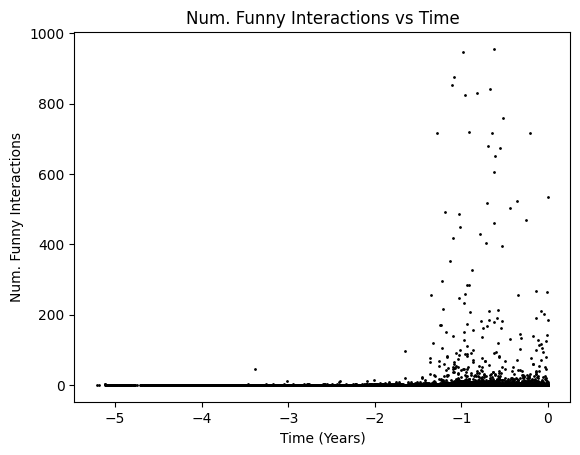

In [95]:
%matplotlib inline

X = []
Y = []
for review in reviews:
    if type(review["posted"]) == datetime:
        X.append(review["posted"].timestamp())
        Y.append(review["funny"])

X = np.array(X)
Y = np.array(Y)

X = X - np.max(X)
X = X / (60*60*24*365)

plt.scatter(X, Y, s=1, color="k")
plt.xlabel("Time (Years)")
plt.ylabel("Num. Funny Ratings")
plt.title("Num. Funny Ratings vs Time")
plt.show()


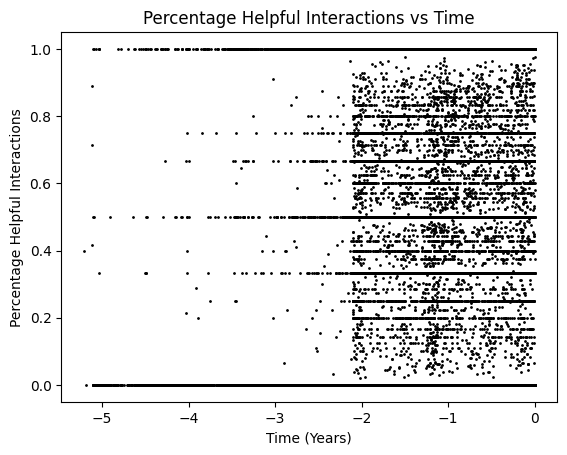

In [96]:
%matplotlib inline

X = []
Y = []
for review in reviews:
    if type(review["posted"]) == datetime:
        X.append(review["posted"].timestamp())
        Y.append(review["helpful"])

X = np.array(X)
Y = np.array(Y)

X = X - np.max(X)
X = X / (60*60*24*365)

plt.scatter(X, Y, s=1, color="k")
plt.xlabel("Time (Years)")
plt.ylabel("Percentage Helpful Ratings")
plt.title("Percentage Helpful Ratings vs Time")
plt.show()


Text(0.5, 1.0, 'Num. Helpful Interactions vs Num. Total Interactions')

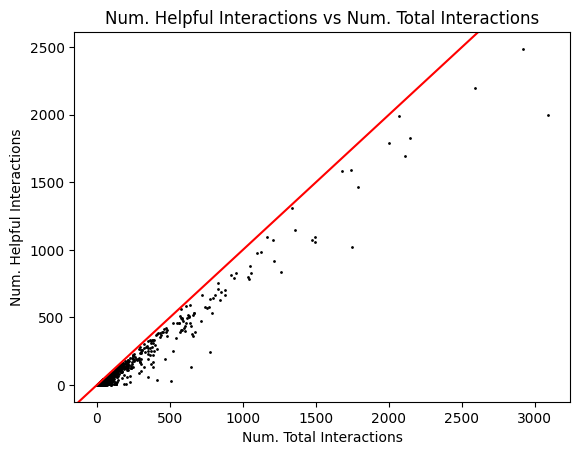

In [108]:
X = []
Y = []
for review in reviews:
    X.append(review["helpful_total"])
    Y.append(review["helpful_n"])

plt.scatter(X,Y,s=1,color="k")
plt.axline((0, 0), slope=1, color="r")
plt.ylabel("Num. Helpful Ratings")
plt.xlabel("Num. Total Ratings")
plt.title("Num. Helpful Ratings vs Num. Total Ratings")